In [211]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pickle
import statsmodels.api as sm

%matplotlib inline

In [259]:
plt.rc('figure', figsize=(18.0, 6.0))

## Load files

Selected dataid 4874 as initial building to test out

In [1124]:
#function to strip timezone from datetime
def strip_tz(row):
    return row['localhour'].strftime('%Y-%m-%d %H:%M:%S')

In [1190]:
df_4874 = pickle.load(open('pickle_files/df_4874.p', 'rb'))
df_4874 = df_4874.sort_values('localhour', ascending=True)
df_4874.index = df_4874.apply(strip_tz, axis=1)

In [1191]:
#set time period to October 2016
df_4874 = df_4874.loc['2016-10-01 00:00:00':'2016-10-31 00:00:00',:]

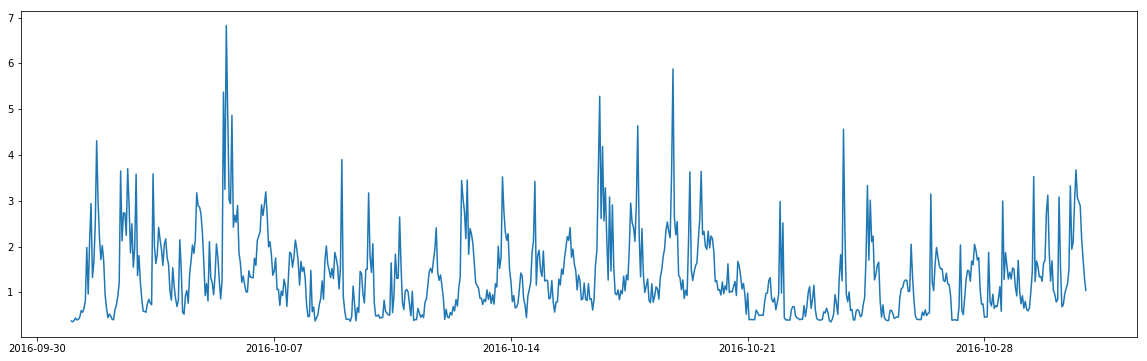

In [1192]:
#plot electricity usage 
plt.subplots(1,1,figsize=(20,6))
plt.plot(df_4874.localhour, df_4874.use)

## AR models

In [1193]:
#function to plot AR time series model with actual usage
def plot_ar_model(model, pred_start, name):

    x = df_4874.localhour
    y_true = df_4874.use
    
    #plot actual usage
    plt.subplots(1,1,figsize=(20,6))
    plt.plot(x,y_true, label='actual usage')
    

    x_pred = x[pred_start:]
    y_pred = model.predict()

    
    #plot model prediction with AR
    plt.plot(x_pred,y_pred, color='red', label='predicted usage')

    plt.title("Electricity Usage of Building 4874 in April 2017 {}".format(name))
    plt.xlabel("Date")
    plt.ylabel("Electricity Consumption (kWh)")
    # plt.yscale('log')
    plt.legend()

AR1

In [1194]:
#hourly_usage must be converted to list
AR1_model = sm.tsa.AR(df_4874.use, freq="H").fit(maxlag=1)
print(AR1_model.params)

const     0.462993
L1.use    0.664593
dtype: float64


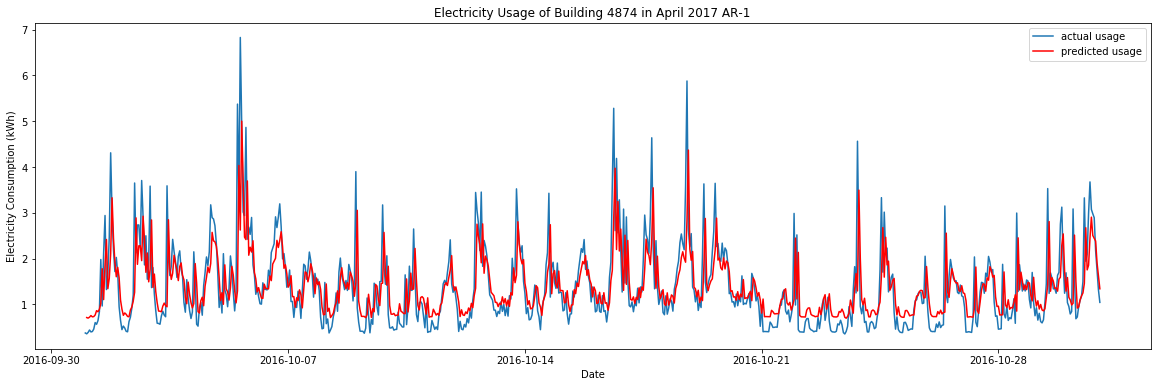

In [1195]:
plot_ar_model(AR1_model, 1, 'AR-1')

AR2

In [1196]:
AR2_model= sm.tsa.AR(df_4874.use, freq="H").fit(maxlag=2)
print(AR2_model.params)

const     0.364730
L1.use    0.519676
L2.use    0.216738
dtype: float64


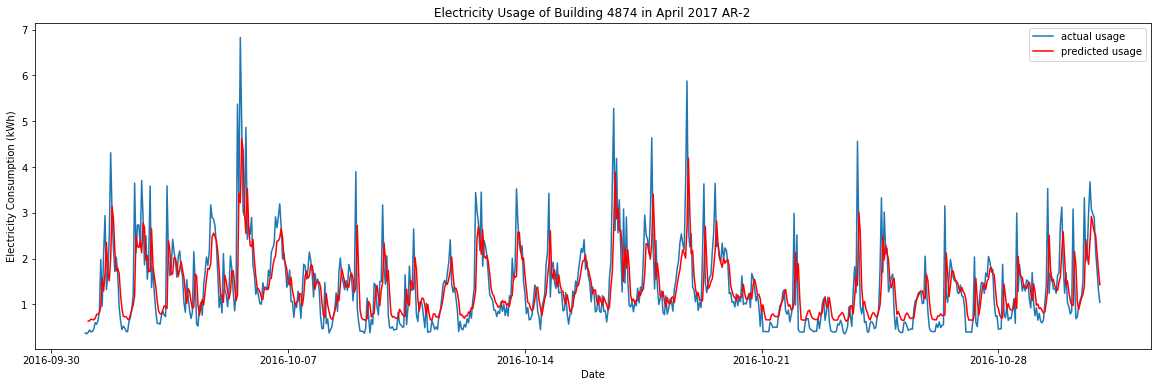

In [1197]:
plot_ar_model(AR2_model, 2, 'AR-2')

AR3

In [1198]:
AR3_model = sm.tsa.AR(df_4874.use, freq="H").fit(maxlag=3)
print(AR3_model.params)

const     0.343813
L1.use    0.506039
L2.use    0.184477
L3.use    0.061408
dtype: float64


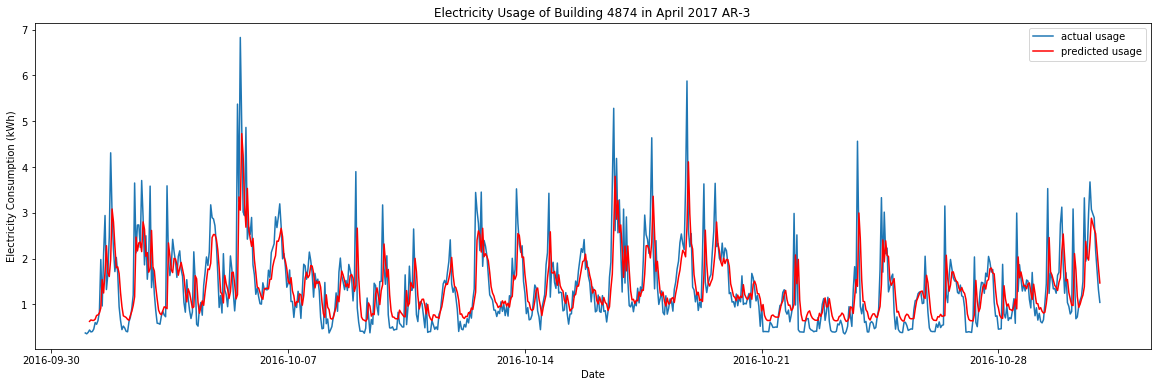

In [1199]:
plot_ar_model(AR3_model, 3, 'AR-3')

## MA models

In [1200]:
#function to plot MA time series model with actual usage
def plot_ma_model(y_select, name):

    x = df_4874.localhour
    y_true = df_4874.use

    #plot actual usage
    plt.subplots(1,1,figsize=(20,6))
    plt.plot(x,y_true, label='actual usage')

    x_pred = x
    y_pred = y_select

    #plot model prediction with MA10
    plt.plot(x_pred,y_pred, color='red', label='predicted usage')

    plt.title("Electricity Usage of Building 4874 in April 2017 {}".format(name))
    plt.xlabel("Date")
    plt.ylabel("Electricity Consumption (kWh)")
    # plt.yscale('log')
    plt.legend()

Moving Average (MA)

In [1201]:
#create new dataframe with time as index
df_4874_new = pd.DataFrame(df_4874.use)
df_4874_new["Hourly_Usage_MA10"] = pd.stats.moments.rolling_mean(df_4874_new, window=10, center=True)
df_4874_new.index = df_4874.apply(strip_tz, axis=1)
df_4874_new = df_4874_new.rename(columns={'use':'Hourly_Usage'})
df_4874_new.index = pd.to_datetime(df_4874_new.index)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:3: FutureWarning: pd.rolling_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(window=10,center=True).mean()
  This is separate from the ipykernel package so we can avoid doing imports until


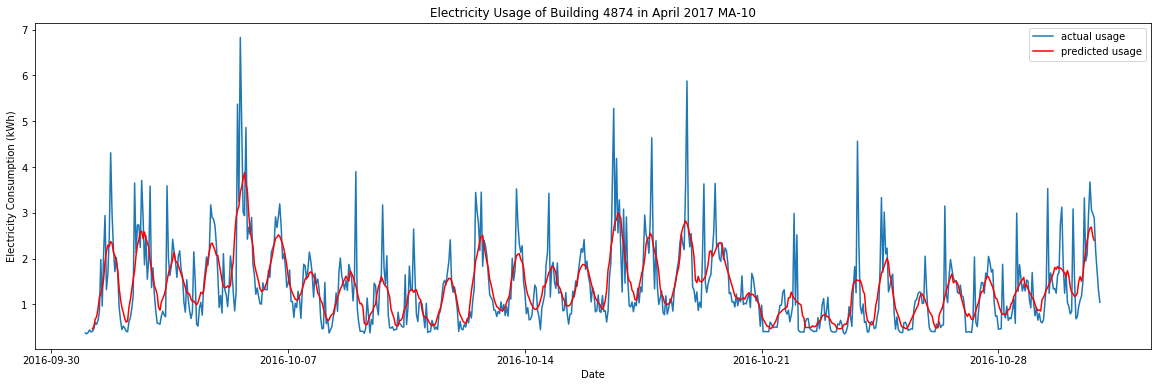

In [1202]:
plot_ma_model(df_4874_new["Hourly_Usage_MA10"], 'MA-10')

EWMA

In [1203]:
ewma= pd.stats.moments.ewma(df_4874_new, halflife=5)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:1: FutureWarning: pd.ewm_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.ewm(min_periods=0,ignore_na=False,adjust=True,halflife=5).mean()
  """Entry point for launching an IPython kernel.


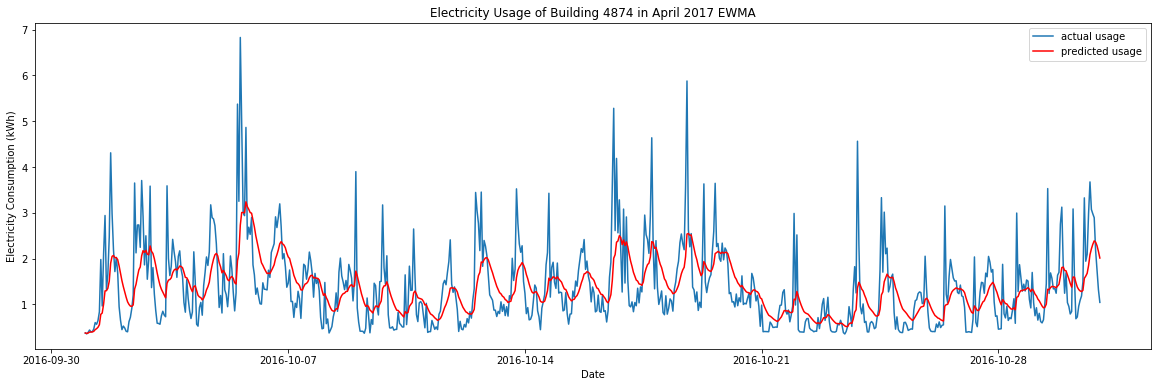

In [1204]:
plot_ma_model(ewma['Hourly_Usage'], 'EWMA')

## ARIMA models

In [1205]:
import itertools
import seasonal
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

### Explore model

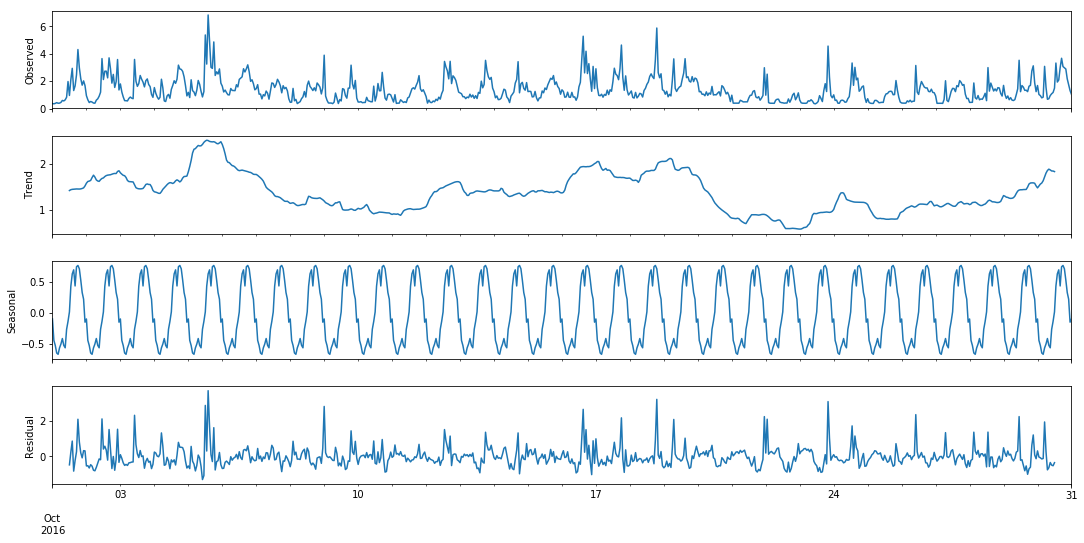

In [1206]:
#plot seasonal decomposition
decomposition = seasonal_decompose(df_4874_new.Hourly_Usage, freq=24)
fig = plt.figure()
fig = decomposition.plot()
fig.set_size_inches(15,8)

In [1207]:
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

In [1208]:
#function to test stationarity
def test_stationarity(timeseries):

    #Determing rolling statistics
    rolmean = pd.rolling_mean(timeseries, window=24)
    rolstd = pd.rolling_std(timeseries, window=24)

    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput) 

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=24,center=False).mean()
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:6: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=24,center=False).std()
  


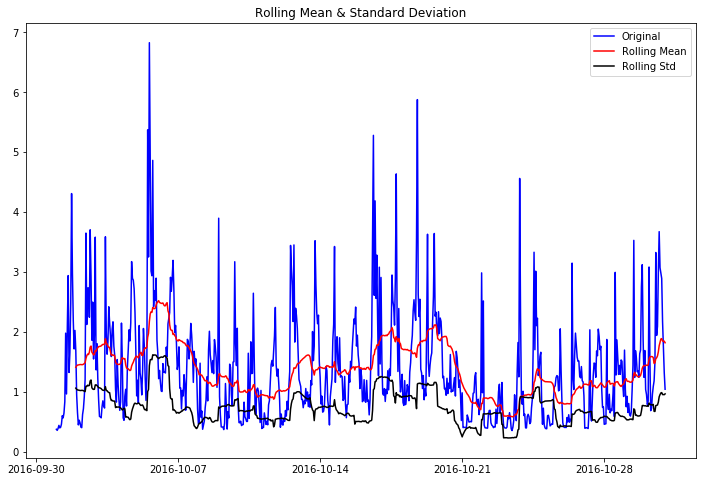

Results of Dickey-Fuller Test:
Test Statistic                  -2.758897
p-value                          0.064389
#Lags Used                      20.000000
Number of Observations Used    700.000000
Critical Value (1%)             -3.439726
Critical Value (5%)             -2.865678
Critical Value (10%)            -2.568973
dtype: float64


In [1209]:
test_stationarity(df_4874_new.Hourly_Usage)

Original time series was already stationary

In [1210]:
df_4874_new['first_difference'] = df_4874_new.Hourly_Usage - df_4874_new.Hourly_Usage.shift(1)
# test_stationarity(df_4874_new.first_difference)

In [1211]:
df_4874_new['seasonal_difference'] = df_4874_new.Hourly_Usage - df_4874_new.Hourly_Usage.shift(24)
# test_stationarity(df_4874_new.seasonal_difference)

In [1212]:
df_4874_new['seasonal_first_difference'] = df_4874_new.first_difference - df_4874_new.first_difference.shift(24)
# test_stationarity(df_4874_new.seasonal_first_difference)

PACF and ACF charts

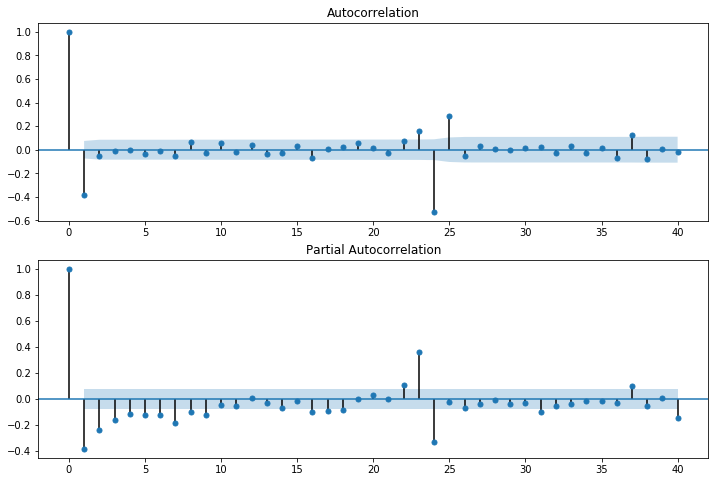

In [1213]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df_4874_new.seasonal_first_difference.iloc[25:], lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df_4874_new.seasonal_first_difference.iloc[25:], lags=40, ax=ax2)

### Optimize order and seasonal order parameters in SARIMAX model

In [656]:
from datetime import datetime
from dateutil.relativedelta import *
import statsmodels.tsa.api as smt
import seaborn as sns

In [657]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 24) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 24)
SARIMAX: (0, 0, 1) x (0, 1, 0, 24)
SARIMAX: (0, 1, 0) x (0, 1, 1, 24)
SARIMAX: (0, 1, 0) x (1, 0, 0, 24)


In [882]:
#function to find optimal parameters and resulting AIC score
def gridsearch_arima(y, exog=None):
    
    p = d = q = range(0, 2)
    pdq = list(itertools.product(p, d, q))
    seasonal_pdq = [(x[0], x[1], x[2], 24) for x in list(itertools.product(p, d, q))]

    low_aic = [0,0,50000]
    
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                model = sm.tsa.statespace.SARIMAX(y,
                                                  exog=exog,
                                                order=param,
                                                seasonal_order=param_seasonal,
                                                enforce_stationarity=False,
                                                enforce_invertibility=False)
                results = model.fit()
                if results.aic < low_aic[2]:
                    low_aic = [param, param_seasonal, results.aic]

#                 print('ARIMA{}x{}24 - AIC:{}'.format(param, param_seasonal, results.aic))
            except:
                continue
    return low_aic

https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.shapiro.html

In [1080]:
#function to create training and testing set
def create_train_test(data, start_train, end_train, start_test, end_test):
    df_train = data.loc[start_train:end_train, :]
    df_test = data.loc[start_test:end_test, :]
    
    start = datetime.strptime(start_test, '%Y-%m-%d %H:%M:%S')
    date_list = [start + relativedelta(hours=x) for x in range(0,24)] #test set will always have 24 hours
    future = pd.DataFrame(index=date_list, columns= df_train.columns)
    df_train = pd.concat([df_train, future])
    
    return df_train, df_test

In [1086]:
# define helper plot function for visualization
def acf_pacf_plots(data, lags=None):
    layout = (1, 3)
    raw  = plt.subplot2grid(layout, (0, 0))
    acf  = plt.subplot2grid(layout, (0, 1))
    pacf = plt.subplot2grid(layout, (0, 2))
    
    data.plot(ax=raw)
    smt.graphics.plot_acf(data, lags=lags, ax=acf)
    smt.graphics.plot_pacf(data, lags=lags, ax=pacf)
    sns.despine()
    plt.tight_layout()

In [1214]:
df_4874_train, df_4874_test = create_train_test(df_4874_new,'2016-10-01 00:00:00','2016-10-30 00:00:00',
                                               '2016-10-30 01:00:00','2016-10-31 00:00:00')

In [1109]:
y_train = df_4874_train.Hourly_Usage
low_aic_1 = gridsearch_arima(y_train)

In [1083]:
low_aic_1

[(1, 0, 1), (0, 1, 1, 24), 1236.1592943448386]

In [1110]:
arima_1 = sm.tsa.statespace.SARIMAX(y_train,
                                  trend=None,
                                  order=low_aic_1[0],
                                  seasonal_order=low_aic_1[1],
                                  enforce_stationarity=False,
                                  enforce_invertibility=False)
results = arima_1.fit()

In [1085]:
print(results.params)

ar.L1       0.851799
ma.L1      -0.493441
ma.S.L24   -0.912977
sigma2      0.373973
dtype: float64


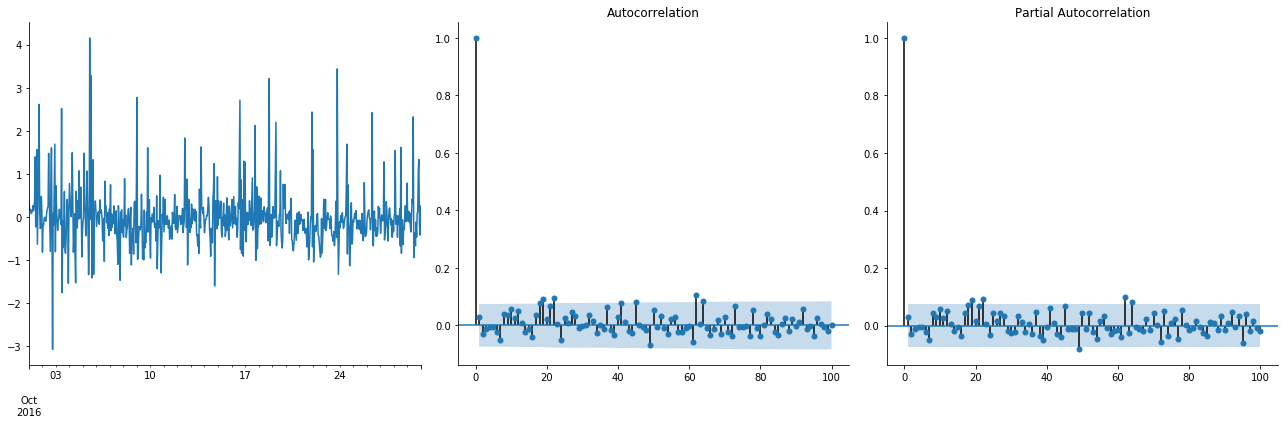

In [1087]:
acf_pacf_plots(results.resid.dropna(), lags=100)

In [1037]:
from sklearn.metrics import mean_squared_error

In [1115]:
#function to forecast with fitted model, returns MSE and RMSE
def add_forecast(model, test, train, start_time, end_time):
    
    train['forecast'] = model.predict(start=start_time, end=end_time)
    y_true = test.loc[start_time:end_time, 'Hourly_Usage']
    y_pred = train.loc[start_time:end_time, 'forecast']
    train.loc[start_time:end_time, 'Hourly_Usage'] = test.loc[start_time:end_time, 'Hourly_Usage']
    
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    
    return mse, rmse

In [1116]:
def plot_forecast(data, datapoints):
    fig = plt.figure(figsize=(16,8))
    plt.plot(data['Hourly_Usage'][datapoints:])
    plt.plot(data['forecast'])
    plt.legend()

(0.70748085589769516, 0.84111881199845673)


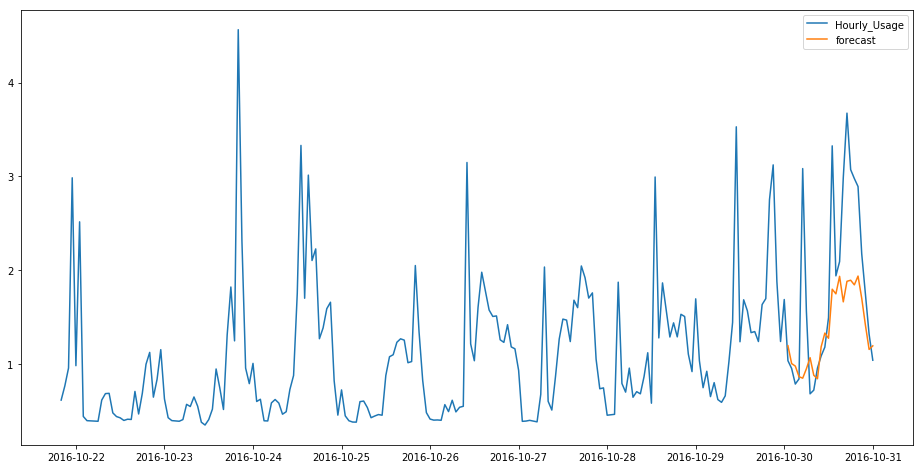

In [1118]:
print(add_forecast(results, df_4874_test, df_4874_train,'2016-10-30 01:00:00','2016-10-31 00:00:00'))
plot_forecast(df_4874_train, 500)

### Add exogenous variables to SARIMAX model

Ideas: day of week (weekend), weather

In [1167]:
type(df_4874_new.index[0]),type(df_weather_austin['localhour'][0])

(pandas._libs.tslib.Timestamp, datetime.datetime)

In [1121]:
y_train.index.hour

Int64Index([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9,
            ...
            15, 16, 17, 18, 19, 20, 21, 22, 23,  0],
           dtype='int64', length=721)

In [733]:
df_weather_austin = pickle.load(open('weather_austin.p', 'rb'))
df_weather_austin = df_weather_austin.sort_values('localhour', ascending=True)
df_weather_austin.index =pd.to_datetime(df_weather_austin.apply(strip_tz, axis=1))

In [1122]:
#function to indicate weekends
def is_weekend(row):
    if row['Day_of_Week'] > 4:
        return 1
    else:
        return 0  

In [1123]:
#function to indicate sleep hours
def is_sleep(row):
    if row['Hour'] < 7:
        return 1
    else:
        return 0

In [1125]:
#function to add all exogenous variables
def add_exog(data, start_time, end_time):
    
    data['Day_of_Week'] = data.index.dayofweek
    data['Weekend'] = data.apply(is_weekend, axis=1)
    data['Temperature'] = df_weather_austin.loc[start_time:end_time, 'temperature']
    
    return data

In [1145]:
df_4874_exog = add_exog(df_4874_train, '2016-10-01 00:00:00', '2016-10-31 00:00:00')

#fill missing temperature values
df_4874_exog['Temperature'] = df_4874_train.Temperature.fillna(np.mean(df_4874_train['Temperature']))

exogenous = df_4874_exog.loc['2016-10-01 00:00:00':,['Weekend','Temperature']].astype(float)
endogenous = df_4874_exog.loc[:,'Hourly_Usage'].astype(float)
exogenous.shape, endogenous.shape

In [1147]:
gridsearch_arima(endogenous,exogenous)

/usr/local/lib/python3.5/dist-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.5/dist-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


[(1, 0, 1), (0, 1, 1, 24), 1275.3275604050395]

In [1164]:
arima_2 = sm.tsa.statespace.SARIMAX(endog=endogenous,
                                  exog = exogenous,
                                  trend=None,
                                  order=(1, 0, 1),
                                  seasonal_order=(0, 1, 1, 24),
                                  enforce_stationarity=False,
                                  enforce_invertibility=False)
results_2 = arima_2.fit()

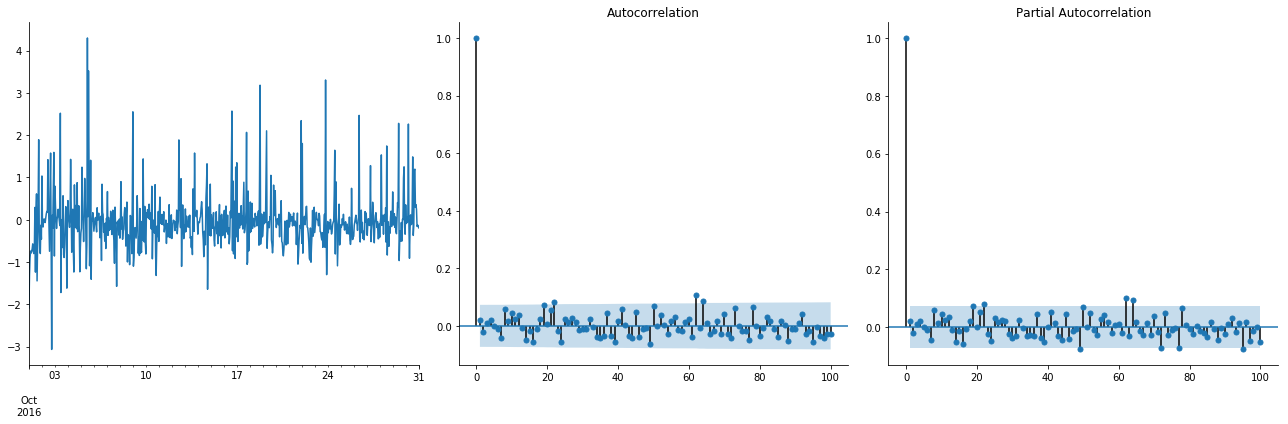

In [1165]:
acf_pacf_plots(results_2.resid.dropna(), lags=100)

In [1150]:
results.aic, results_2.aic

(1236.1592943448386, 1275.3275604050395)

Worse AIC score but let's see if the MSE is better

In [1155]:
df_4874_exog_train, df_4874_exog_test = create_train_test(df_4874_exog,'2016-10-01 00:00:00','2016-10-30 00:00:00',
                                               '2016-10-30 01:00:00','2016-10-31 00:00:00')

(0.48780565223530076, 0.69843085000256167)


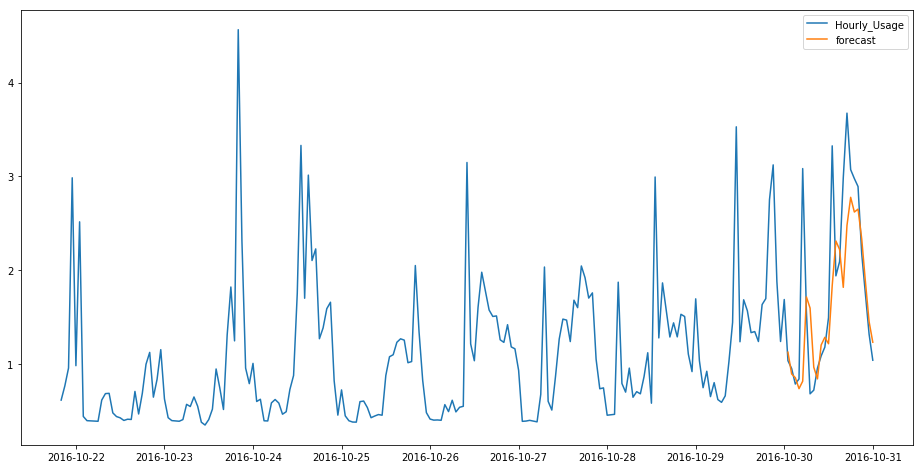

In [1156]:
print(add_forecast(results_2, df_4874_exog_test, df_4874_exog_train,'2016-10-30 01:00:00','2016-10-31 00:00:00'))
plot_forecast(df_4874_exog_train, 500)

Improved MSE with exogenous variables! Maybe add more

## GARCH model

In [1168]:
import arch

In [1215]:
df_4874.index = pd.to_datetime(df_4874.apply(strip_tz, axis=1))
arch_model = arch.arch_model(df_4874.use, p=1, q=1)
results_3 = arch_model.fit(update_freq=5)
print(results_3.summary)

Iteration:      5,   Func. Count:     37,   Neg. LLF: 857.5600862542149
Iteration:     10,   Func. Count:     70,   Neg. LLF: 856.513665306034
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 856.5133810330773
            Iterations: 12
            Function evaluations: 82
            Gradient evaluations: 12
<bound method ARCHModelResult.summary of                      Constant Mean - GARCH Model Results                      
Dep. Variable:                    use   R-squared:                      -0.059
Mean Model:             Constant Mean   Adj. R-squared:                 -0.059
Vol Model:                      GARCH   Log-Likelihood:               -856.513
Distribution:                  Normal   AIC:                           1721.03
Method:            Maximum Likelihood   BIC:                           1739.35
                                        No. Observations:                  721
Date:                Tue, Sep 12 2017   Df Residuals:

In [1216]:
arch_forecast.variance.index[:-25]

DatetimeIndex(['2016-10-01 00:00:00', '2016-10-01 01:00:00',
               '2016-10-01 02:00:00', '2016-10-01 03:00:00',
               '2016-10-01 04:00:00', '2016-10-01 05:00:00',
               '2016-10-01 06:00:00', '2016-10-01 07:00:00',
               '2016-10-01 08:00:00', '2016-10-01 09:00:00',
               ...
               '2016-10-30 14:00:00', '2016-10-30 15:00:00',
               '2016-10-30 16:00:00', '2016-10-30 17:00:00',
               '2016-10-30 18:00:00', '2016-10-30 19:00:00',
               '2016-10-30 20:00:00', '2016-10-30 21:00:00',
               '2016-10-30 22:00:00', '2016-10-30 23:00:00'],
              dtype='datetime64[ns]', length=720, freq=None)

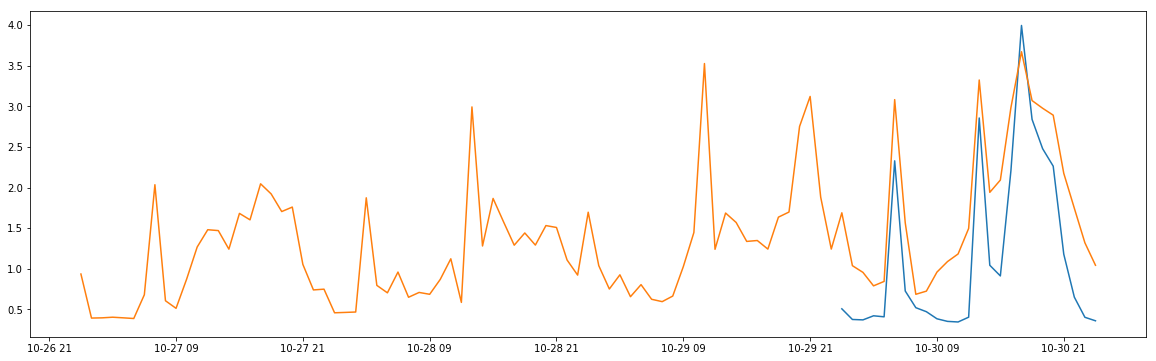

In [1229]:
plt.subplots(1,1,figsize=(20,6))
arch_forecast = results_3.forecast(start='2016-10-30 00:00:00')
plt.plot(df_4874.localhour, arch_forecast.variance)
plt.plot(df_4874.loc['2016-10-27 00:00:00':'2016-10-31 00:00:00', 'localhour'],df_4874.loc['2016-10-27 00:00:00':'2016-10-31 00:00:00', 'use'])

In [1230]:
mean_squared_error(df_4874.loc['2016-10-30 00:00:00':,'use'], arch_forecast.variance[-25:])

0.5585321707362042

## Facebook Prophet

In [1237]:
from fbprophet import Prophet

ImportError: No module named 'fbprophet'

-------

## Holt-Winters... needs further investigation

In [44]:
import seasonal as hw

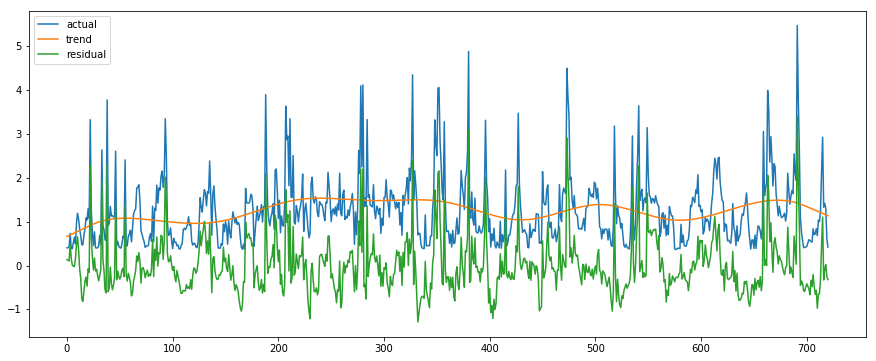

In [45]:
seasons, trend = hw.fit_seasons(y_true)
adjusted = hw.adjust_seasons(y_true, seasons=seasons)
residual = adjusted - trend
plt.subplots(1,1, figsize=(15,6))
plt.plot(y_true, label='actual')
plt.plot(trend, label='trend')
plt.plot(residual, label='residual')
plt.legend()